<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/2plane_ConvDBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

The model is designed to classify grayscale MRI images for detecting normal menisci or meniscus tears. The input images, resized to 256x256xs 17 in this case, undergo preprocessing steps, including splicing and applying a White Top Hat filter to enhance features.
* The preprocessed images are then fed into a conv2D exctracting the features, to feature map of 256x256x3 that passed into the pre-trained DenseNet121
architecture, which has been modified to exclude its top classification layers.
* The DenseNet121 model processes the input and outputs feature maps, which are subsequently passed through a Global Average Pooling layer, reducing the spatial dimensions into a 1D vector.
* Concate the sagittal and coronal plane. This concatenation step merges the spatial features extracted from both planes.
* A Batch Normalization layer is applied to stabilize the network and improve learning performance.
* The feature vector is then fed into a Dense Layer with 1024 units and ReLU activation to extract high-level features, followed by a Dropout Layer to mitigate overfitting.
A second Dense Layer, also with 512 units and ReLU activation, further refines the feature space.
* Finally, the model outputs predictions through a Dense Layer with 2 units and sigmoid activation, representing the probabilities of the two classes (normal or meniscus tear).

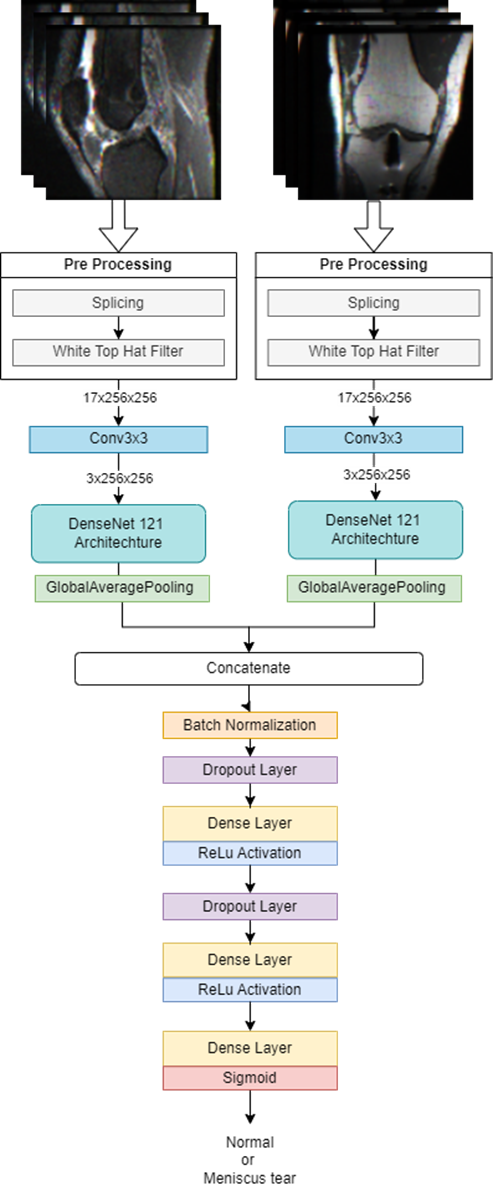

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install opencv-python
!pip install matplotlib
!pip install numpy

## Data import

**import data and get labels**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **data generation for meniscus**

In [4]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
def data_gen(dataset_type,path, plane, diagnosis):
    '''this function gets the data from the extracted datset'''

    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform17d' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'

    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


In [5]:
# generate training input
BASE_PATH = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

coronal_mensicus, coronal_mensicus_label = data_gen('train',BASE_PATH, 'coronal/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train',BASE_PATH, 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid',BASE_PATH, 'coronal/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid',BASE_PATH, 'sagittal/extracted_images', 'meniscus')

print(coronal_mensicus_val.shape)

(1130, 17, 256, 256)
(120, 17, 256, 256)


##  Hyperparameters

In [7]:
# Define your parameters
IMAGE_SIZE= 256  # Adjust based on your actual image dimensions
IMAGE_DEPTH = 17
NUM_CLASSES = 1
CHANNELS = 1

batch_size = 16
nb_epoch = 50
dropout = 0.4
lr = 5e-5 # Learning rat

In [8]:
 # Assuming axial_mensicus, coronal_mensicus, and sagittal_mensicus are your input arrays
# Reshape your data to add the channel dimension
coronal_mensicus = coronal_mensicus.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)
sagittal_mensicus = sagittal_mensicus.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)
coronal_mensicus_val = coronal_mensicus_val.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)
sagittal_mensicus_val = sagittal_mensicus_val.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)

In [9]:
# Assuming mensicus_label is initially a list, convert it to a NumPy array
coronal_mensicus_label = np.array(coronal_mensicus_label)
sagittal_mensicus_label = np.array(sagittal_mensicus_label)

In [10]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

## Model Creation and training

In [11]:
# Convert input data to float32 and print shapes to check
coronal_mensicus = np.transpose(coronal_mensicus, (0, 2, 3, 1)).astype('float32')
sagittal_mensicus = np.transpose(sagittal_mensicus, (0, 2, 3, 1)).astype('float32')
coronal_mensicus_val = np.transpose(coronal_mensicus_val, (0, 2, 3, 1)).astype('float32')
sagittal_mensicus_val = np.transpose(sagittal_mensicus_val, (0, 2, 3, 1)).astype('float32')

In [12]:
# Ensure that coronal_mensicus and sagittal_mensicus are NumPy arrays
coronal_mensicus = np.asarray(coronal_mensicus)
sagittal_mensicus = np.asarray(sagittal_mensicus)
coronal_mensicus_val = np.asarray(coronal_mensicus_val)
sagittal_mensicus_val = np.asarray(sagittal_mensicus_val)

# Labels should also be NumPy arrays
coronal_mensicus_label = np.asarray(coronal_mensicus_label)
coronal_mensicus_label_val = np.asarray(coronal_mensicus_label_val)

# Check shapes to ensure they're correct
print(coronal_mensicus.shape)  # Should be (num_samples, 256, 256, 17)
print(sagittal_mensicus.shape)  # Should be (num_samples, 256, 256, 17)
print(coronal_mensicus_val.shape)
print(sagittal_mensicus_val.shape)
print(coronal_mensicus_label.shape)

(1130, 256, 256, 17)
(1130, 256, 256, 17)
(120, 256, 256, 17)
(120, 256, 256, 17)
(1130,)


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling1D, Reshape, Conv2D
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint
def create_model2(input_shape, NUM_CLASSES, dropout):
    # Base DenseNet model
    base_model = DenseNet121(weights=None, include_top=False, pooling=None, input_shape=(256,256,1))

    # Define input for each plane
    input_coronal = Input(shape=input_shape, name='input_coronal')
    input_sagittal = Input(shape=input_shape, name='input_sagittal')

    # 3x3 Convolution eith filter=1 to reduce depth from 17 to 1 for each plane
    conv_coronal = Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(input_coronal)
    conv_sagittal = Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same')(input_sagittal)

    # Process each plane using the same base DenseNet model
    coronal_output = base_model(conv_coronal)
    sagittal_output = base_model(conv_sagittal)

    # Global Average Pooling for each plane
    coronal_output = GlobalAveragePooling2D()(coronal_output)
    sagittal_output = GlobalAveragePooling2D()(sagittal_output)

    # Concatenate the outputs from all planes
    concatenated = Concatenate()([coronal_output, sagittal_output])

    # Dense and Dropout layers after concatenation
    x = BatchNormalization()(concatenated)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)

    output = Dense(NUM_CLASSES, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=[input_coronal, input_sagittal], outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

if __name__ == '__main__':
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 17)
    model = create_model2(input_shape, NUM_CLASSES, dropout)
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Train the model with axial, coronal, and sagittal planes
    history = model.fit([coronal_mensicus, sagittal_mensicus],
                        coronal_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=([coronal_mensicus_val, sagittal_mensicus_val], coronal_mensicus_label_val),
                        callbacks=callbacks_list)




Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.5469 - loss: 0.7398
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to bestmodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5470 - loss: 0.7397 - val_accuracy: 0.5667 - val_loss: 0.7906
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5565 - loss: 0.7206
Epoch 2: val_accuracy improved from 0.56667 to 0.57500, saving model to bestmodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.5568 - loss: 0.7206 - val_accuracy: 0.5750 - val_loss: 0.7159
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5582 - loss: 0.7456
Epoch 3: val_accuracy did not improve from 0.57500
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.5584 - loss: 0.7453 - val_accuracy: 0.5667 - val_loss: 0.7072
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5976 - loss: 0.7389
Epoch 4: val_accuracy did not improve from 0.57500
71/71 ━━━━━━━━━━━━━━━━━━━━ 17

In [19]:
 # Evaluate the model
predictions_valid = model.predict([coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
score = log_loss(coronal_mensicus_label_val, predictions_valid)

model.summary()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_coronal             │ (None, 256, 256, 17)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sagittal            │ (None, 256, 256, 17)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 1)    │            154 │ input_coronal[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 1)    │            154 │ input_sagittal[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 8, 8, 1024)     │      7,031,232 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[1][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2048)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048)           │          8,192 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1024)           │      2,098,176 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        524,800 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            513 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,291,116 (46.89 MB)

 Trainable params: 2,627,893 (10.02 MB)

 Non-trainable params: 7,035,328 (26.84 MB)

 Optimizer params: 2,627,895 (10.02 MB)

## Model evaluation

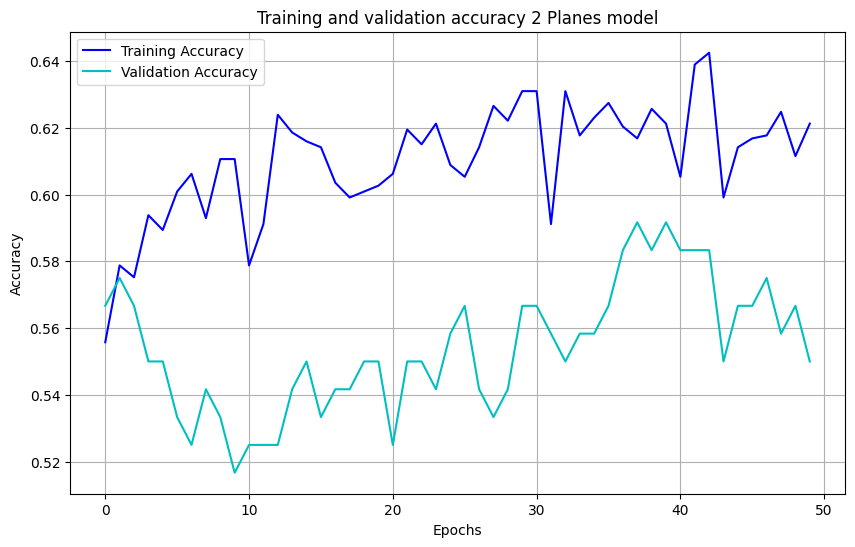

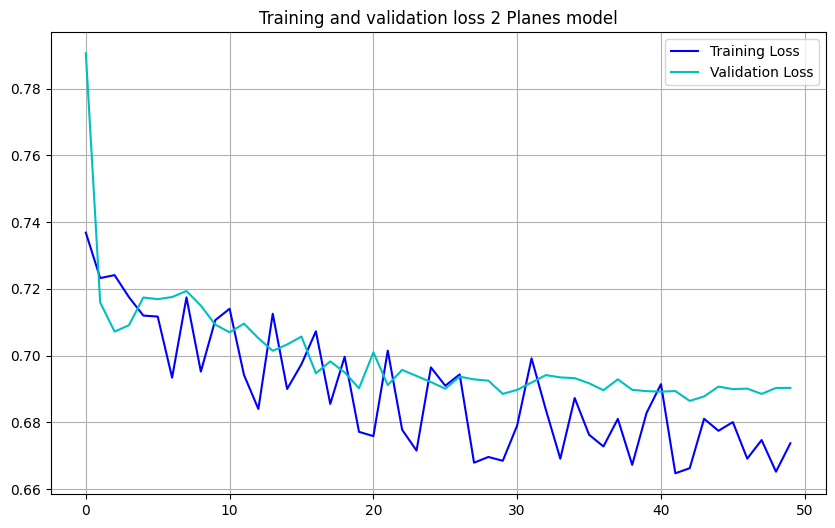

In [15]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'c',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title(f'Training and validation accuracy 2 Planes model')
plt.grid(True)
plt.legend()
plt.savefig(f'Training and validation accuracy 2 Planes model.png')




#Plot training and validation loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'c',label='Validation Loss')


plt.title(f'Training and validation loss 2 Planes model')
plt.savefig(f'Training and validation loss 2 Planes model.png')
plt.grid(True)
plt.legend()

plt.show()


In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss,confusion_matrix

# Threshold predictions: Convert probabilities to binary labels (0 or 1)
threshold = 0.5
predictions_valid_binary = (predictions_valid > threshold).astype(int)
score = log_loss(coronal_mensicus_label_val, predictions_valid)
acc = accuracy_score(coronal_mensicus_label_val, predictions_valid_binary)
precision = precision_score(coronal_mensicus_label_val, predictions_valid_binary)
recall = recall_score(coronal_mensicus_label_val, predictions_valid_binary)
conf_matrix = confusion_matrix(coronal_mensicus_label_val, predictions_valid_binary)


print(f"Log Loss: {score}")
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("Confusion Matrix:")
print(conf_matrix)

Log Loss: 0.690314831806132
Accuracy: 0.55
Precision: 0.4375
Recall: 0.1346153846153846
Confusion Matrix:
[[59  9]
 [45  7]]


In [17]:
model.save("2plane_ConvDBN.keras")
from google.colab import files
files.download('2plane_ConvDBN.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
files.download("Training and validation accuracy 2 Planes model.png")
files.download("Training and validation loss 2 Planes model.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>